# Problems

- For 50M training samples, we see a negative mse for the training set. This is wierd, as the training set should always have a positive mse.
- For 1M training samples, we see behavior as expected.

In [6]:
data = th.load("/workspace/data/checkpoints/feature_scaler/L13-mu0.0e+00-lr1e-03-s42-Individual-alllatents-ZeroInit/checkpoint_95000.pt")

/tmp/ipykernel_10187/3400623964.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = th.load("/workspace/data/checkpoints/feature_scaler/L13-mu0.0e+00-lr1e-03-s42-Indi

In [7]:
data

OrderedDict([('scaler',
              tensor([ -5.6468, -17.7664,  -0.0608,  ...,  -1.0694, -18.3035, -10.1738],
                     device='cuda:0'))])

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from pathlib import Path
import torch as th
import numpy as np
from matplotlib import pyplot as plt
from tools.utils import CCLatent

chat_indices = th.load(Path("/workspace/data/only_it_decoder_feature_indices.pt"))

/tmp/ipykernel_22089/2353518161.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chat_indices = th.load(Path("/workspace/data/only_it_decoder_feature_indices.pt"))


In [50]:


def load_scalers(results_dir: Path, model_name: str, num_samples: int, n_offset: int = 0, special_results_dir: str = "", suffix: str = ""):
    if special_results_dir:
        scalers_path = results_dir / special_results_dir / model_name / f"betas_base_error_N{num_samples}_n_offset{n_offset}{suffix}.pt"
    else:
        scalers_path = results_dir / model_name / f"betas_base_error_N{num_samples}_n_offset{n_offset}{suffix}.pt"
    return th.load(scalers_path, weights_only=True)

def load_count_active(results_dir: Path, model_name: str, num_samples: int, n_offset: int = 0, special_results_dir: str = "", suffix: str = ""):
    if special_results_dir:
        count_active_path = results_dir / special_results_dir / model_name / f"count_active_base_error_N{num_samples}_n_offset{n_offset}{suffix}.pt"
    else:
        count_active_path = results_dir / model_name / f"count_active_base_error_N{num_samples}_n_offset{n_offset}{suffix}.pt"
    return th.load(count_active_path, weights_only=True)

def load_stats(results_dir: Path, model_name: str, num_samples: int, n_offset: int = 0, special_results_dir: str = "", suffix: str = ""):
    if special_results_dir:
        stats_path = results_dir / special_results_dir / model_name / f"stats_base_error_N{num_samples}_n_offset{n_offset}{suffix}.pt"
    else:
        stats_path = results_dir / model_name / f"stats_base_error_N{num_samples}_n_offset{n_offset}{suffix}.pt"
    return th.load(stats_path)

def plot_scalers_diff(betas, counts, name_a, name_b, relative: bool = False, log_scale_x: bool = False):
    if relative:
        diff = (betas[name_a] - betas[name_b]).abs() / th.max(betas[name_a], betas[name_b])
    else:
        diff = (betas[name_a] - betas[name_b]).abs()
    counts_a = counts[name_a]
    counts_b = counts[name_b]
    counts_a = counts_a[~th.isnan(diff)]
    counts_b = counts_b[~th.isnan(diff)]
    diff = diff[~th.isnan(diff)]

    nan_idx_to_original_idx = th.arange(len(diff))[~th.isnan(diff).cpu()]
    def get_latent_from_idx(idx):
        return CCLatent(chat_indices[nan_idx_to_original_idx[idx]].item())
    print("Max diff:", diff.max().item(), " Counts:", counts_a[diff.argmax()].item(), counts_b[diff.argmax()].item(), "Max Act:", get_latent_from_idx(diff.argmax()).max_act_unscaled)
    print("Median diff:", diff.median().item())
    print("Mean diff:", diff.mean().item())
    print("Min diff:", diff.min().item(), " Counts:", counts_a[diff.argmin()].item(), counts_b[diff.argmin()].item(), "Max Act:", get_latent_from_idx(diff.argmin()).max_act_unscaled)
    if log_scale_x:
        diff = th.log(diff)
    plt.hist(diff.cpu().numpy(), bins=100)
    plt.xlabel("Absolute Difference in Beta Values")
    plt.ylabel("Count")
    plt.title(f"Distribution of Differences Between {name_a} and {name_b}")
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.show()

def plot_stats_buckets(stats, name, show_train: bool = True, show_val: bool = True):
    SAME_Y = True
    if show_train:
        mse_buckets_train = stats[name + "-train"]["mse_buckets"] 
        mse_buckets_before_train = stats[name + "-train"]["mse_before_buckets"]
        perc_improvement_train = -(mse_buckets_train - mse_buckets_before_train) / mse_buckets_before_train

    mse_buckets_val = stats[name + "-validation"]["mse_buckets"]
    mse_buckets_before_val = stats[name + "-validation"]["mse_before_buckets"]
    perc_improvement_val = -(mse_buckets_val - mse_buckets_before_val) / mse_buckets_before_val

    if show_train:
        mse_buckets_train = stats[name + "-train"]["mse_buckets"] 
        mse_buckets_before_train = stats[name + "-train"]["mse_before_buckets"]
        perc_improvement_train = -(mse_buckets_train - mse_buckets_before_train) / mse_buckets_before_train

    # Create histogram of differences between MSE buckets
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"MSE Percentage Improvement by Activation Bucket for {name}")

    # Get max count across all buckets for consistent y-axis
    max_count = 0
    for i in range(3):
        counts_val, _ = np.histogram(perc_improvement_val[i][~np.isnan(perc_improvement_val[i])], bins=100)
        counts_train, _ = np.histogram(perc_improvement_train[i][~np.isnan(perc_improvement_train[i])], bins=100)
        max_count = max(max_count, counts_val.max(), counts_train.max())

    bucket_labels = ["0-33%", "33-66%", "66-100%"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        if show_val:
            plt.hist(perc_improvement_val[i][~np.isnan(perc_improvement_val[i])], bins=100, alpha=0.5, label='Validation', color='blue')
        if show_train:
            plt.hist(perc_improvement_train[i][~np.isnan(perc_improvement_train[i])], bins=100, alpha=0.5, label='Train', color='red')
        plt.title(f"Bucket {bucket_labels[i]}")
        plt.xlabel("Percentage Improvement")
        plt.ylabel("Count")
        plt.legend()
        if SAME_Y:
            plt.ylim(0, max_count*1.1)

    plt.tight_layout()
    plt.show()

def get_negative_improvement_features(stats, name, split, threshold: float = 0.0):
    """
    Calculate which features have negative percentage improvement across all buckets.
    
    Args:
        stats: Dictionary containing MSE statistics
        name: Name of the experiment
        
    Returns:
        numpy array: Boolean mask indicating which features have negative improvement in all buckets
    """
    mse_buckets = stats[name + "-" + split]["mse_buckets"]
    mse_buckets_before = stats[name + "-" + split]["mse_before_buckets"]
    perc_improvement = -(mse_buckets - mse_buckets_before) / mse_buckets_before
    

    mse_overall = stats[name + "-" + split]["mse"]
    mse_before_overall = stats[name + "-" + split]["mse_before"]
    perc_improvement_overall = -(mse_overall - mse_before_overall) / mse_before_overall

    # Check if improvement is negative across all buckets
    is_negative = np.ones(perc_improvement.shape[1], dtype=bool)
    for bucket in range(perc_improvement.shape[0]):
        is_negative &= (perc_improvement[bucket] < threshold) & ~np.isnan(perc_improvement[bucket])

    # Print features with negative improvement
    if np.any(is_negative):
        print(f"\nFeatures with negative improvement (below {threshold}):")
        negative_indices = np.where(is_negative)[0]
        for idx in negative_indices:
            improvements = [perc_improvement[bucket][idx] for bucket in range(perc_improvement.shape[0])]
            print(f"Feature {idx}: Improvements across buckets = {[f'{x:.3f}' for x in improvements]}")
            print(f"Overall improvement: {perc_improvement_overall[idx]:.3f}")
    return is_negative


def plot_stats_mse(stats, name, show_train: bool = True, show_val: bool = True, threshold: float = -1e-3):
    if show_train:
        mse_train = stats[name + "-train"]["mse"]
        mse_before_train = stats[name + "-train"]["mse_before"]
        perc_improvement_train = -(mse_train - mse_before_train) / mse_before_train
        print(f"Train split has {np.sum((perc_improvement_train < threshold) & ~np.isnan(perc_improvement_train))} negative improvements - Min: {np.nanmin(perc_improvement_train).item()}, Max: {np.nanmax(perc_improvement_train).item()}")

    if show_val:
        mse_val = stats[name + "-validation"]["mse"]
        mse_before_val = stats[name + "-validation"]["mse_before"]
        perc_improvement_val = -(mse_val - mse_before_val) / mse_before_val
        print(f"Validation split has {np.sum((perc_improvement_val < threshold) & ~np.isnan(perc_improvement_val))} negative improvements - Min: {np.nanmin(perc_improvement_val).item()}, Max: {np.nanmax(perc_improvement_val).item()}")

    if show_train:
        plt.hist(perc_improvement_train, bins=100, alpha=0.5, label="Train", color="red")
    if show_val:
        plt.hist(perc_improvement_val, bins=100, alpha=0.5, label="Validation", color="blue")
    plt.xlabel("Percentage Improvement")
    plt.ylabel("Count")
    plt.title(f"Percentage Improvement for {name}")
    plt.legend()
    plt.show()


In [51]:
# Load all scalers

betas = {
    "50M": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 50_000_000, 0),
    "10M": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp"),
    "10M_fp64": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp", "_fp64"),
    "1M": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp"),
    "1M-shufflewithin": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, suffix="_shufflewithin"),
    "1M-1": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 1),
    "1M-2": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2),
    "1M-5epochs": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_stacked_5e"),
    "1M-10epochs": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_stacked_10e"),
    "500k-4": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 500_000, 4),
}

count_active = {
    "50M": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 50_000_000, 0),
    "10M": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp"),
    "1M": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp"),
    "1M-shufflewithin": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, suffix="_shufflewithin"),
    "1M-1": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 1),
    "1M-2": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2),
    "1M-5epochs": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_stacked_5e"),
    "1M-10epochs": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_stacked_10e"),
    "500k-4": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 500_000, 4),
}

stats = {
    "10M-train": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp", "_train"),
    "10M-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp", "_validation"),
    "1M-train": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_train"),
    "1M-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_validation"),
    "1M-2-train": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, suffix="_train"),
    "1M-2-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, suffix="_validation"),
    "1M-2-val-1-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, suffix="_NT1000000_n_offset_train2_validation"),
}

/tmp/ipykernel_22089/2608259185.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(stats_path)


Validation split has 0 negative improvements - Min: -2.7144453485212863e-10, Max: 0.0002495161320612034


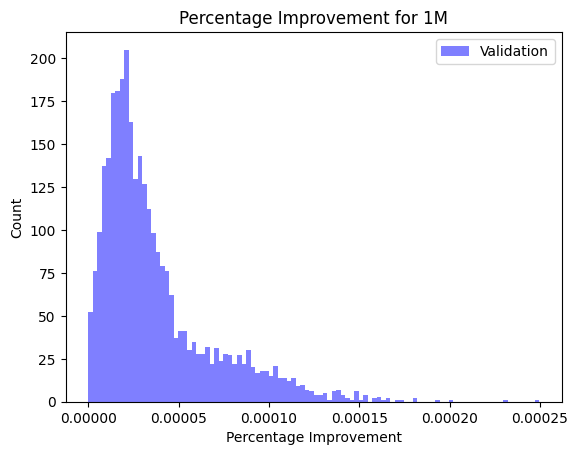

In [55]:
plot_stats_mse(stats, "1M", show_train=False)

In [56]:
get_negative_improvement_features(stats, "1M-2", "train", threshold=-1e-3).sum()


Features with negative improvement (below -0.001):
Feature 14: Improvements across buckets = ['-0.001', '-0.012', '-0.035']
Overall improvement: -0.000
Feature 200: Improvements across buckets = ['-0.001', '-0.014', '-0.057']
Overall improvement: -0.000
Feature 470: Improvements across buckets = ['-0.001', '-0.013', '-0.038']
Overall improvement: -0.000
Feature 929: Improvements across buckets = ['-0.001', '-0.014', '-0.095']
Overall improvement: -0.000
Feature 1045: Improvements across buckets = ['-0.001', '-0.014', '-0.025']
Overall improvement: -0.000
Feature 1197: Improvements across buckets = ['-0.002', '-0.018', '-0.061']
Overall improvement: -0.000
Feature 1397: Improvements across buckets = ['-0.001', '-0.017', '-0.061']
Overall improvement: -0.000
Feature 1445: Improvements across buckets = ['-0.001', '-0.017', '-0.038']
Overall improvement: -0.000
Feature 1496: Improvements across buckets = ['-0.001', '-0.027', '-0.077']
Overall improvement: -0.000
Feature 1597: Improvements

np.int64(23)

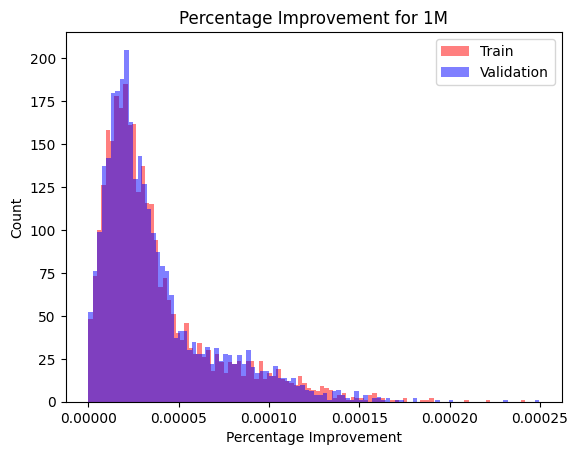

In [10]:
plot_stats_mse(stats, "1M")

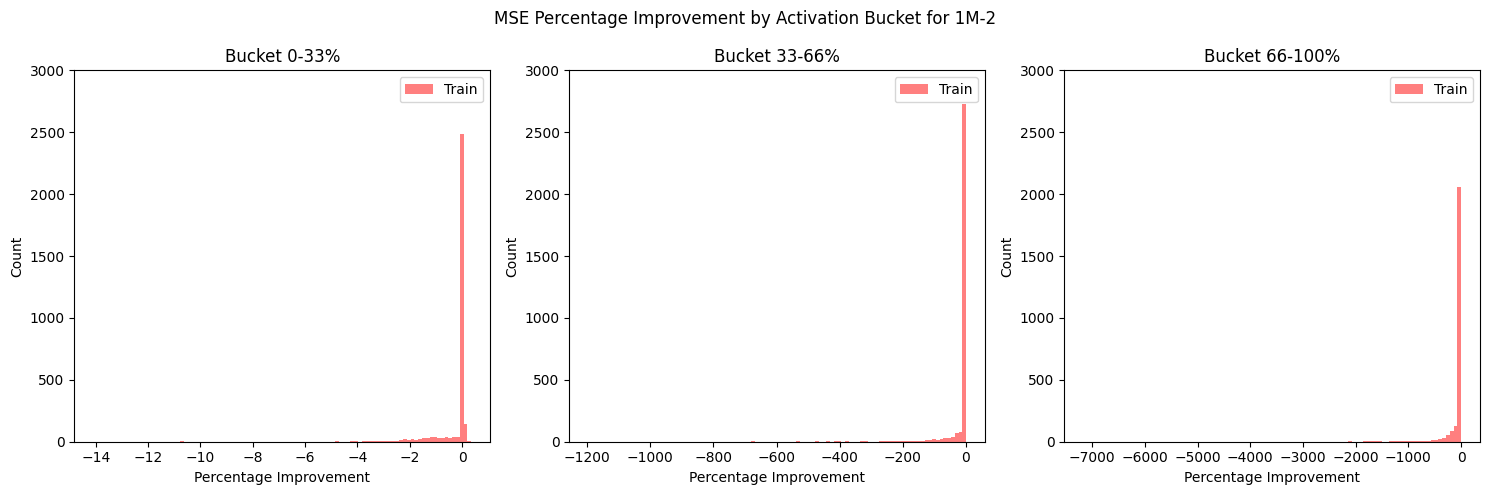

In [8]:
plot_stats_buckets(stats, "1M-2", show_val=False)


## Comparison of scalers

Max diff: 4698.565946696439  Counts: 8236.0 1095.0 Max Act: 41.999477
Median diff: 0.8192045604427101
Mean diff: 5.087680480930532
Min diff: 1.7164182599227473e-05  Counts: 25798.0 4734.0 Max Act: 59.525005


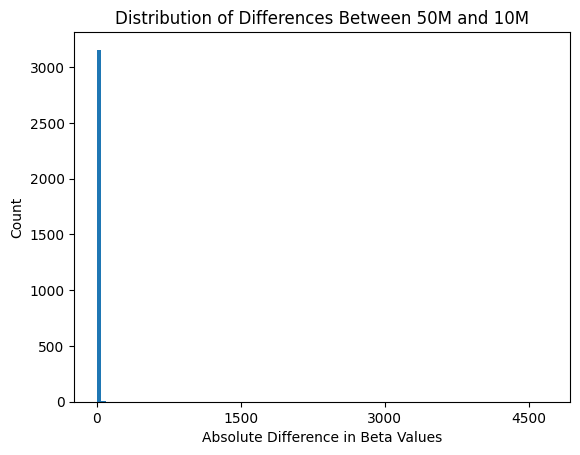

In [5]:
plot_scalers_diff(betas, count_active, "50M", "10M")

Max diff: 3996.358915446439  Counts: 8236.0 111.0 Max Act: 41.999477
Median diff: 1.0499391604071775
Mean diff: 7.651245077323261
Min diff: 0.0002531601844338871  Counts: 21993.0 381.0 Max Act: 57.39031


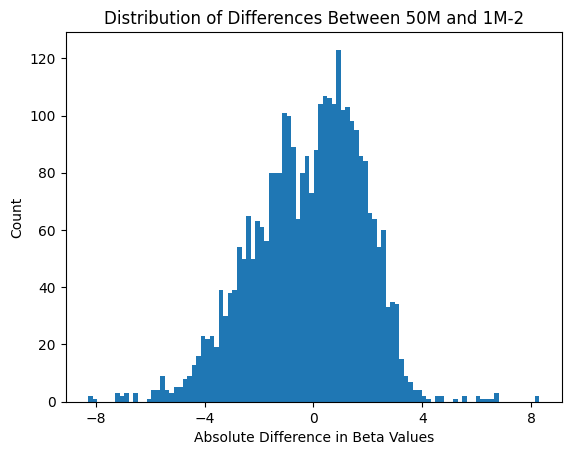

In [6]:
plot_scalers_diff(betas, count_active, "50M", "1M-2", log_scale_x=True)

Max diff: 0.00018167495727539062  Counts: 16439.0 82195.0 Max Act: 53.573845
Median diff: 7.152557373046875e-07
Mean diff: 1.640453433537914e-06
Min diff: 0.0  Counts: 4407.0 22035.0 Max Act: 39.83676


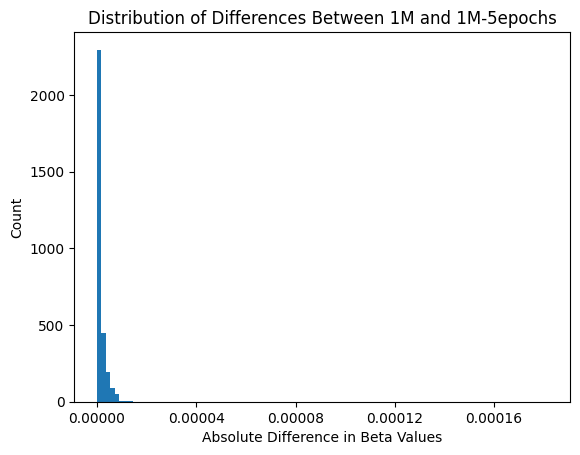

Max diff: 0.0003075599670410156  Counts: 16439.0 164390.0 Max Act: 53.573845
Median diff: 1.5497207641601562e-06
Mean diff: 3.8599114304815885e-06
Min diff: 0.0  Counts: 9248.0 92480.0 Max Act: 85.220856


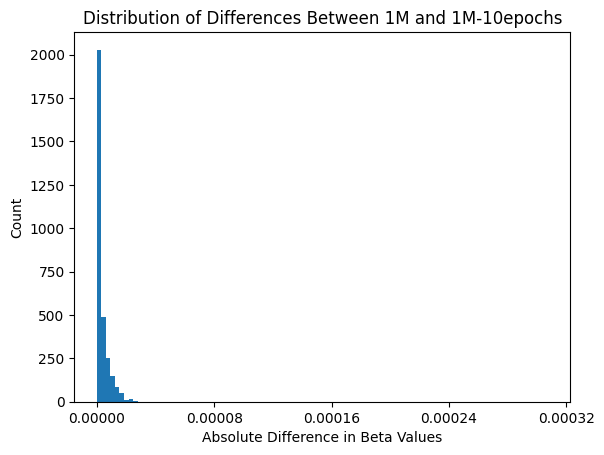

In [7]:
plot_scalers_diff(betas, count_active, "1M", "1M-5epochs")
plot_scalers_diff(betas, count_active, "1M", "1M-10epochs")


Max diff: 0.5590505599975586  Counts: 1689.0 1950.0 Max Act: 79.303894
Median diff: 0.03671765327453613
Mean diff: 0.04811568558216095
Min diff: 1.6450881958007812e-05  Counts: 6349.0 6817.0 Max Act: 56.14775


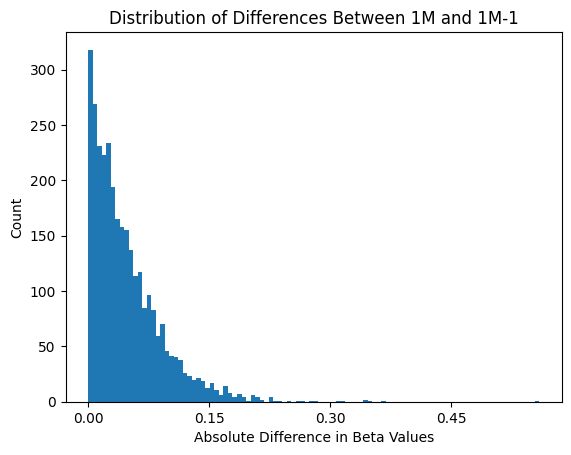

Max diff: 1254.718017578125  Counts: 2.0 918.0 Max Act: 49.39294
Median diff: 12.324371337890625
Mean diff: 24.65880012512207
Min diff: 0.00027954578399658203  Counts: 1820.0 2408.0 Max Act: 59.928158


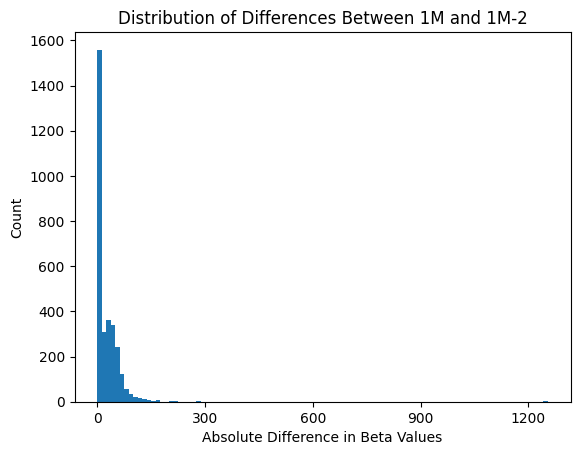

Max diff: 4.7326087951660156e-05  Counts: 16458.0 16458.0 Max Act: 65.31543
Median diff: 4.172325134277344e-07
Mean diff: 8.334044423463638e-07
Min diff: 0.0  Counts: 8318.0 8318.0 Max Act: 77.42117


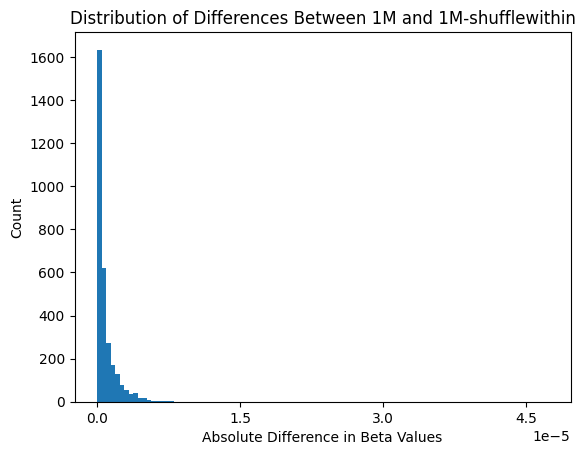

In [8]:
plot_scalers_diff(betas, count_active, "1M", "1M-1")
plot_scalers_diff(betas, count_active, "1M", "1M-2")
plot_scalers_diff(betas, count_active, "1M", "1M-shufflewithin")


# MSE improvement


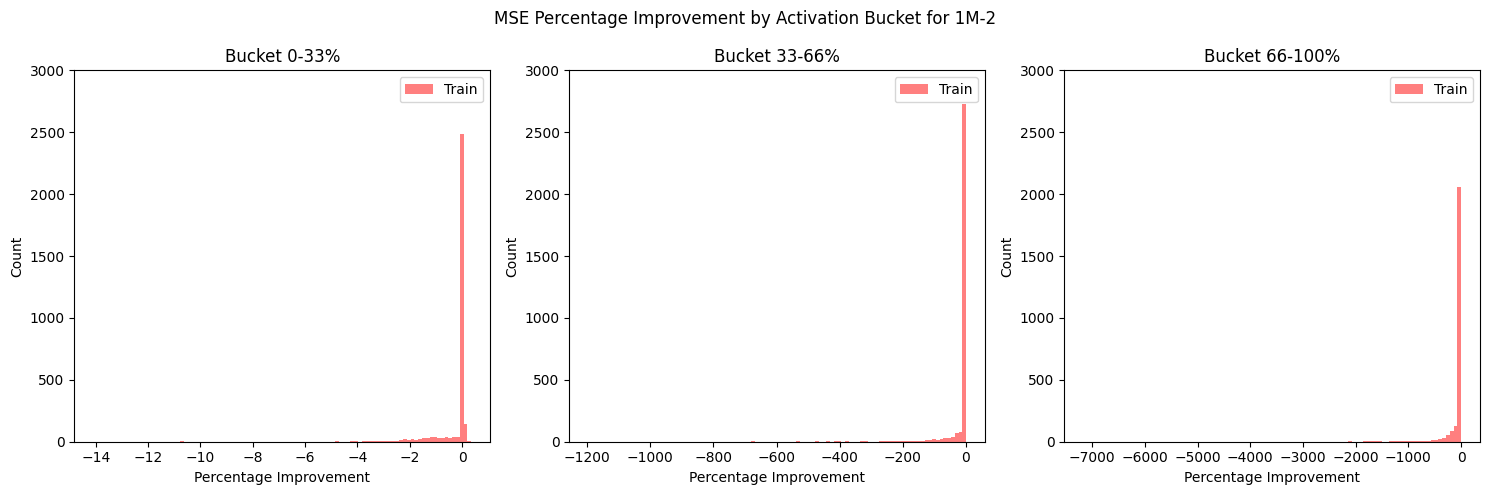

In [17]:
plot_stats_buckets(stats, "1M-2", show_val=False)

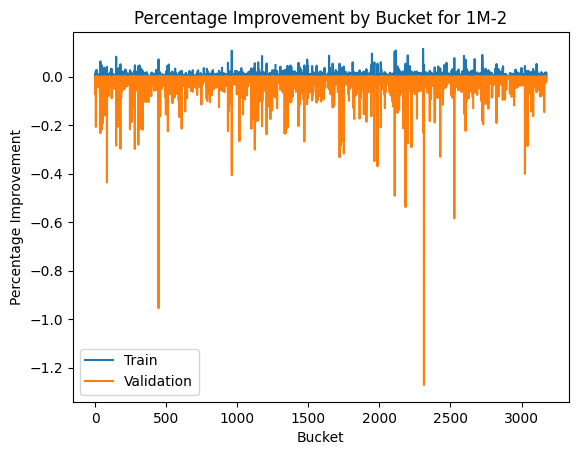

In [20]:
plot_stats_mse(stats, "1M-2")

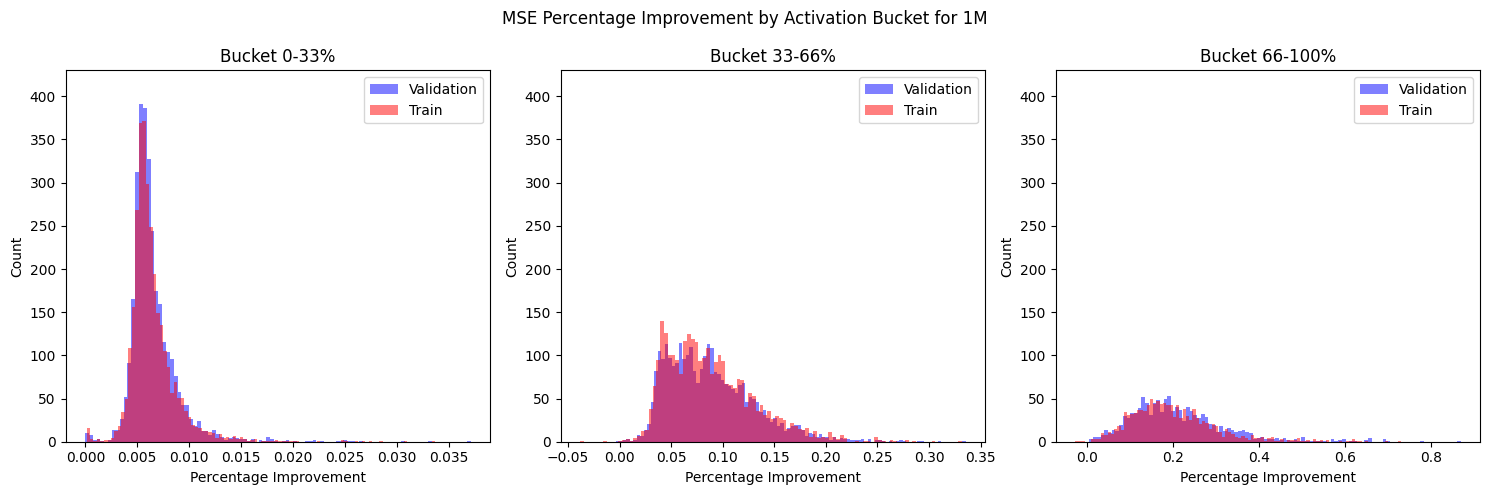

In [10]:
plot_stats_buckets(stats, "1M")

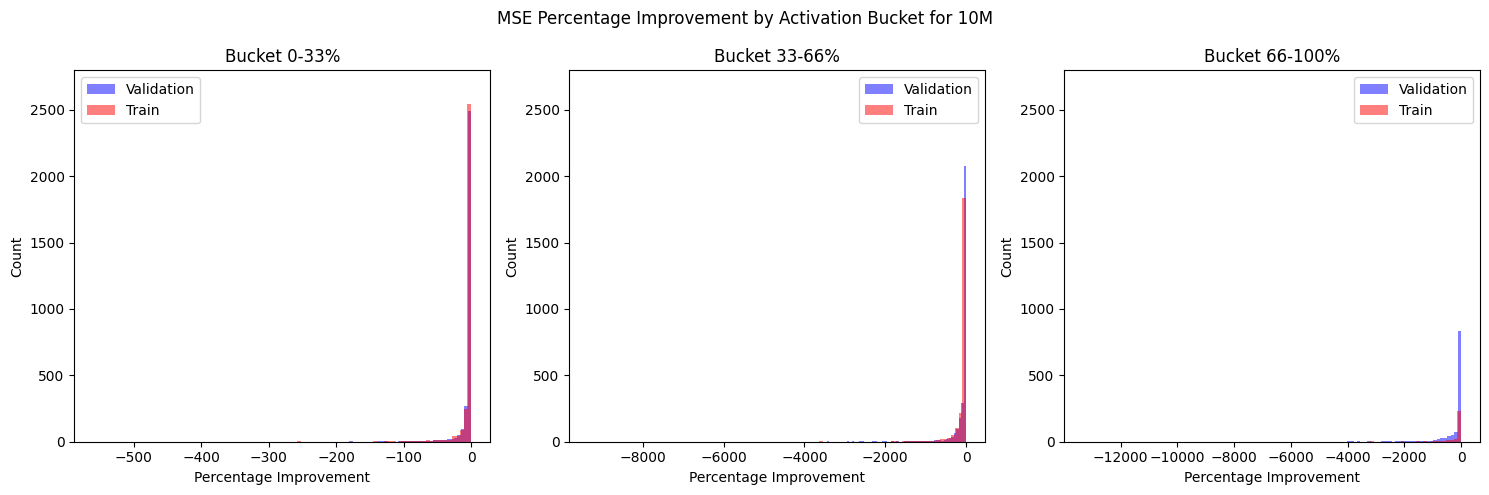

In [32]:
plot_stats_buckets(stats, "10M")